## Финальный отчёт проекта "Идентификация интернет-пользователей"

**Цель проекта** - идентификация пользователя по его поведению в сети Интернет. Есть некоторый определенный пользователь (Alice). Сессия - последовательность из нескольких веб-сайтов, посещенных подряд одним человеком. Даны сессии Alice, а также сессии неизвестного пользователя, для каждой из которых необходимо определить, кому она принадлежит (Alice или кому-то другому).  
Для решения данной задачи построим модель бинарной классификации, которая для каждой сессии будет вычислять вероятность того, что эта сессия принадлежит Alice. Чем ближе эта вероятность к 1, тем больше уверенность модели в том, что эта сессия принадлежит Alice, и чем ближе вероятность к 0, тем больше модель уверена в обратном.

### Описание данных
Для каждого сайта в сессии имеется его ID и время посещения. Длина каждой сессии - не более 10 сайтов. Словарь site_dic.pkl связывает домены сайтов и их ID. В файле train_sessions.csv также имеется целевой признак target, принимающий значения 0 или 1 (принадлежит ли сессия Alice), которые нужно предсказать для данных из test_sessions.csv.  

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
PATH_TO_DATA = 'data/'

### Первичный анализ признаков

Загрузим тренировочный и тестовый датасет, заполним пропущенные значения нулями, преобразуем колонки с временем в нужный формат. Объедим данные в один датафрейм и разделим его на 2 части: первый содержит время, второй - ID сайтов. Выделим целевой признак в переменную y.

In [2]:
sites = ['site%d' % n for n in range(1, 11)]
times = ['time%d' % n for n in range(1, 11)]
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col = 'session_id', parse_dates = times)
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col = 'session_id', parse_dates = times)
all_df = pd.concat([train, test], sort = False)

site_df = all_df[sites]
time_df = all_df[times]
y = train['target'].astype('int').values

train.fillna(0)
test.fillna(0)
display(train.head())
test.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


### Cоздание признаков для визуального анализа

Создадим датафрейм features, в который поместим некоторые признаки из тренировочной выборки, а именно: час, день недели и месяц начала каждой сессии.

In [3]:
features = pd.DataFrame(index = site_df.index)
time_train = train[times]
features['start_hour'] = time_train['time1'].dt.hour
features['week_day'] = time_train['time1'].dt.dayofweek
features['month'] = time_train['time1'].dt.strftime('%y.%m')
features['y'] = train['target']
features

,start_hour,week_day,month,y
session_id,,,,
1,10,3,14.02,0
2,11,5,14.02,0
3,16,0,13.12,0
4,10,4,14.03,0
5,10,4,14.02,0
...,...,...,...,...
82793,8,2,14.03,0
82794,8,0,14.03,0
82795,13,3,13.12,0


### Визуальный анализ данных
#### Распределение сессий по часам

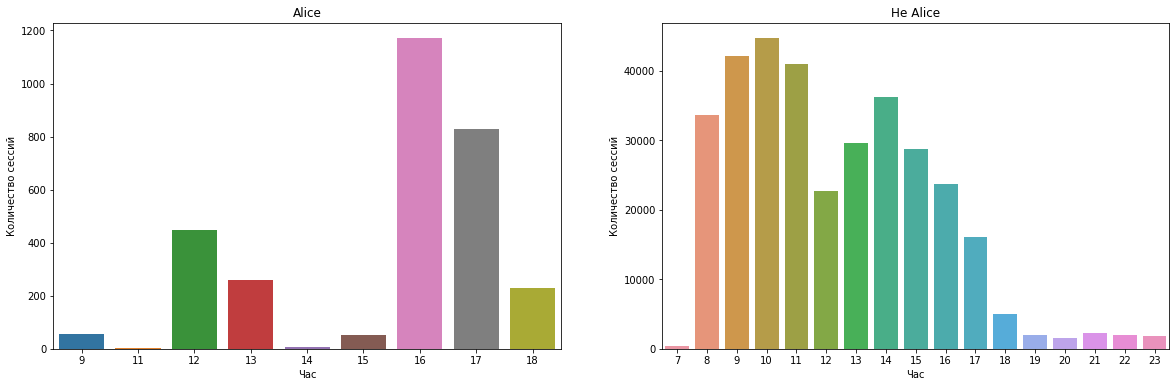

In [4]:
t = ['Alice', 'Не Alice']
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
for i in range(2):
    sns.countplot('start_hour', data = features[features['y'] == 1-i], ax = ax[i])\
    .set(title = t[i], xlabel = 'Час', ylabel = 'Количество сессий')

Разница распределений очевидна. Наибольшее время в интернете  Alice проводит в 16-17 часу, намного меньше - в 12-13 часу. В остальные часы Alice почти не заходит в сеть.  
У не Alice 2 пика активности - в 10 и 14 часу, при этом в промежутке с 8 до 17 часов активность достаточно высока, и только с 18 часов она резко понижается.  
#### Распределение сессий по дням недели

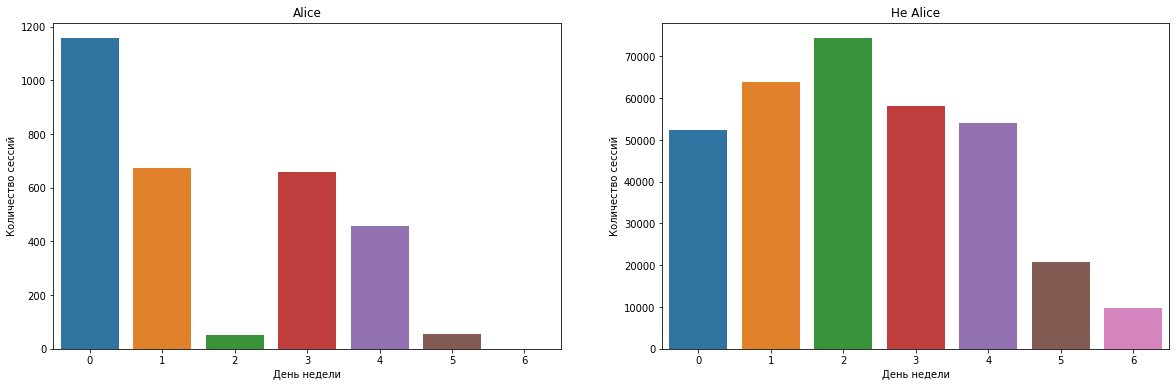

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
for i in range(2):
    sns.countplot('week_day', data = features[features['y'] == 1-i], ax = ax[i])\
    .set(title = t[i], xlabel = 'День недели', ylabel = 'Количество сессий')

Наибольшая активность у Alice - в понедельник, значительно меньше - во вторник, четверг и пятницу, в среду и выходные - практически отсутствует.  
У не Alice распределение активности нормальное в будни, снижается в выходные.
#### Распределение сессий по месяцам

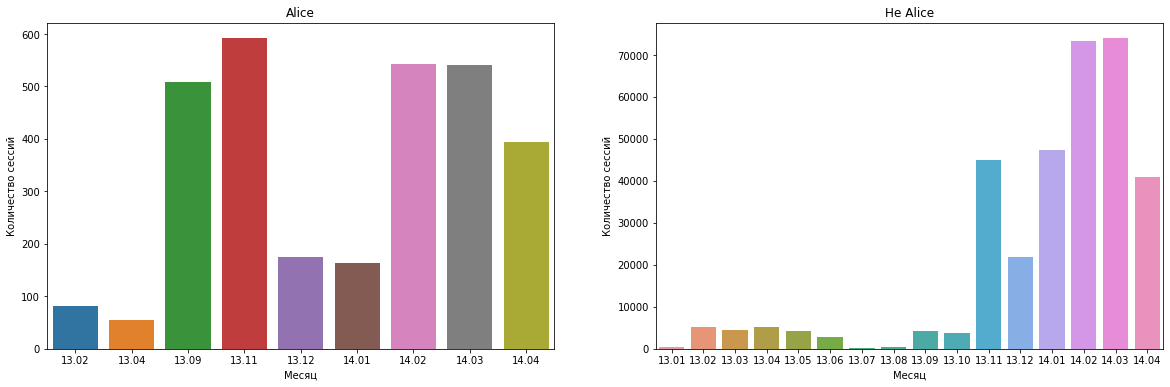

In [6]:
features.sort_values(by = 'month', inplace = True)
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
for i in range(2):
    sns.countplot('month', data = features[features['y'] == 1-i], ax = ax[i])\
    .set(title = t[i], xlabel = 'Месяц', ylabel = 'Количество сессий')   

В январе, марте, с мая по август и в октябре 2013 года активность у Alice отсутствовала. Пики активности - ноябрь 2013 и февраль-март 2014 года.  
У не Alice в первые 10 месяцев 2013 года активность стабильно низкая, затем резко возрастает в ноябре, падает в декабре, и снова увеличивается, достигая максимума в феврале-марте 2014 года.   
В целом, распределения активности по месяцам имеют видимое сходство. 

### Обработка данных и создание признаков для обучения моделей  

Создадим новый признак - количество вхождений сайта в сессию. В итоге получается разреженная матрица, элементами которой являются числа вхождений каждого сайта в каждую сессию. Используем меру подсчёта обратной частоты вхождений TF-IDF.  

Также создадим признаки:
* daytime - время суток: 0 - ночь, 1 - утро, 2 - день, 3 - вечер, кодирование признака с помощью OneHotEncoder
* weekend - бинарный признак, определяющий, является ли день выходным 
* year_month - год и месяц (в виде одного 4-значного числа), кодирование признака с помощью MaxAbsScaler  

Поместим все признаки в разреженную матрицу, и выделим тренировочный и тестовый датасет.

In [9]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    dic = pickle.load(f)
    
train = train.sort_values(by = 'time1')
train_part = len(train)
params = {'ngram_range': (1, 5), 'max_features': 50000, 
          'tokenizer': lambda s: s.split(), 'stop_words': ['unknown']}

dic1 = {v:k for (k, v) in dic.items()}
dic1[0] = 'unknown'
    
X_text = [' '.join([str(x) for x in map(dic1.get, i)]) if len(i) > 0 else '' for i in site_df.values]
    
vectorizer = TfidfVectorizer(**params)
vectorizer.fit(X_text[:train_part])

count = Counter()
for v in site_df.values:
    count.update(v)
popular = [i for i, j in count.most_common(30)]
pop_id = np.isin(site_df.values, popular)
li = []
for n, m in zip(site_df.values, pop_id):
    pops = n[m]
    li.append(len(pops))
    
features = pd.DataFrame(index = site_df.index)    
features['popular'] = li


def daytime(h):
    if 0 <= h <= 6:
        return 0
    elif 7 <= h <= 11:
        return 1
    elif 12 <= h <= 18:
        return 2
    elif 19 <= h <= 23:
        return 3
    
features['start_hour'] = time_df['time1'].dt.hour
features['week_day'] = time_df['time1'].dt.dayofweek    
features['daytime'] = features['start_hour'].apply(daytime)
features['year_month'] = time_df['time1'].dt.strftime('%y%m').astype(int)
features['weekend'] = features['week_day'].isin([5, 6])
    
encoded = OneHotEncoder(sparse = True, dtype = np.int16)\
       .fit_transform(features[['daytime']].values)
scaled = MaxAbsScaler().fit_transform(features[['week_day', 'year_month']].values)


all_features = csr_matrix(hstack([vectorizer.transform(X_text), 
          csr_matrix(hstack([encoded, scaled]))]))
X_train = all_features[:train_part]
X_test = all_features[train_part:]


Функция для построения кривых логистической регрессии:

In [10]:
def plot_curves(p, results):
    values = list(p.items())[0][1]
    plt.figure(figsize = (12, 8))
    m_train, s_train = results['mean_train_score'], results['std_train_score']
    m_test, s_test = results['mean_test_score'], results['std_test_score']
    print('Стандартное отклонение: {}'.format(max(zip(s_train, s_test), key = lambda x: x[0])[1]))
    plt.semilogx(values, m_train, '-', label = 'Score на тренировочном датасете', color = 'g')
    plt.semilogx(values, m_test, '-', label = 'Score на кросс-валидации', color = 'b')
    plt.xlabel('alpha', fontsize = 15)
    plt.ylabel('Score', fontsize = 15)
    plt.legend()

### Обучение моделей
Начнём обучение модели логистической регресии. Используем также стохастический градиентный спуск (SDGClassifier) для ускорения процесса.

In [11]:
s = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)

In [18]:
def log_sgd(p):
    log = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1)
    log_search = GridSearchCV(log, param_grid = p, cv = s, scoring = 'roc_auc', return_train_score = True)
    log_search.fit(X_train, y)

    a = log_search.best_params_['alpha']
    score = log_search.best_score_
    print('Лучшее значение alpha: ', a)
    print('Лучшее значение ROC-AUC score: ', score)
    plot_curves(p, log_search.cv_results_)
    return log_search.best_estimator_

Осуществим поиск alpha на промежутке от 1e-6 до 1e+3, используя GridSearchCV.

Лучшее значение alpha:  1e-06
Лучшее значение ROC-AUC score:  0.9755087904420053
Стандартное отклонение: 0.008060094629684674


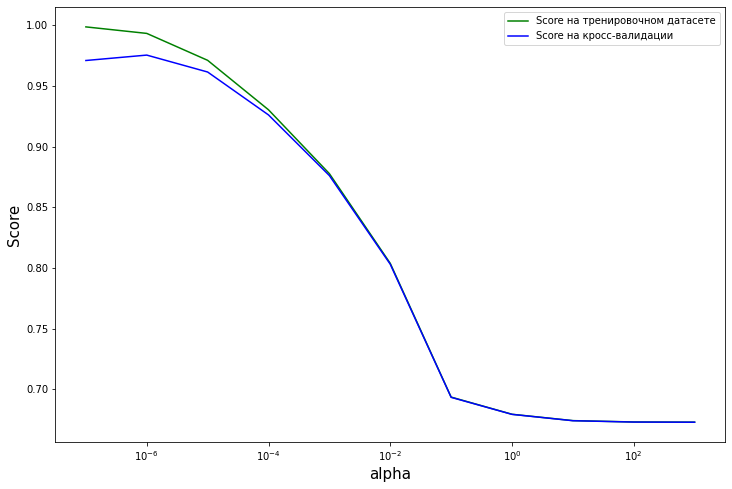

In [19]:
p = {'alpha': np.logspace(-7, 3, 11)}
est = log_sgd(p)

Увеличим масштаб на промежутке, где Score достигает максимума.

Лучшее значение alpha:  7.356422544596422e-07
Лучшее значение ROC-AUC score:  0.9765671646057001
Стандартное отклонение: 0.0028803001670554265


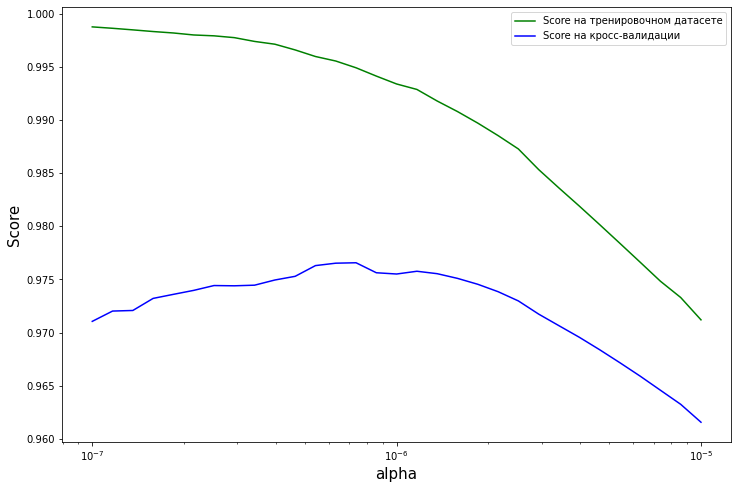

In [20]:
p1 = {'alpha': np.logspace(-7, -5, 31)}
est = log_sgd(p1)

Новое значение alpha увеличило AUC-ROC на кросс-валидации и уменьшило стандартное отклонение.  
Построим кривые обучения:

In [21]:
def plot_learning_curve(estimator):    
    t_sizes, t, v = learning_curve(estimator, X_train, y, 
         train_sizes = np.linspace(0.1, 1.0, 20), cv = s)
    t_mean = np.mean(t, axis = 1)
    v_mean = np.mean(v, axis = 1)
    plt.figure(figsize = (12, 8))
    plt.xlabel('Число объектов в выборке', fontsize = 15)
    plt.ylabel('Score', fontsize = 15)
    plt.plot(t_sizes, t_mean, 'o-', color = 'g', label = 'Score на тренировочном датасете')
    plt.plot(t_sizes, v_mean, 'o-', color = 'b', label = 'Score на кросс-валидации')
    plt.legend()
    plt.grid()
    plt.tight_layout()

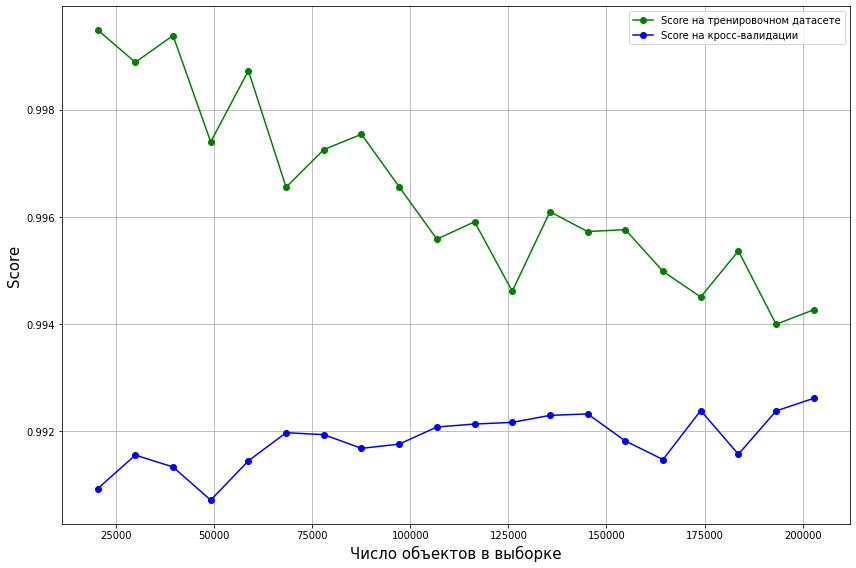

In [22]:
plot_learning_curve(est)

Из графика кривых обучения видно, что разница между качеством на тренировочной выборке и на кросс-валидации сокращается с увеличением объёма данных. Для уменьшения разрыва обучим модель логистической регрессии, используя обычный градиентный спуск.  

In [23]:
def log_normal(p):
    log = LogisticRegressionCV(Cs = p, cv = s, scoring = 'roc_auc', 
            multi_class = 'ovr', random_state = 17, n_jobs = -1)
    log.fit(X_train, y)
    s_log = log.scores_[1]
    sm_log = np.apply_along_axis(np.mean, 0, s_log)
    best_C, best_score = max(zip(p, sm_log), key = lambda x: x[1])
    print('Лучшее значение C: ', best_C)
    print('Лучшее значение ROC-AUC score: ', best_score)
    plt.figure(figsize = (12, 8))
    plt.grid()
    plt.plot(p, sm_log)
    plt.xscale('log')
    return best_C

Лучшее значение C:  10.0
Лучшее значение ROC-AUC score:  0.9769412042874734


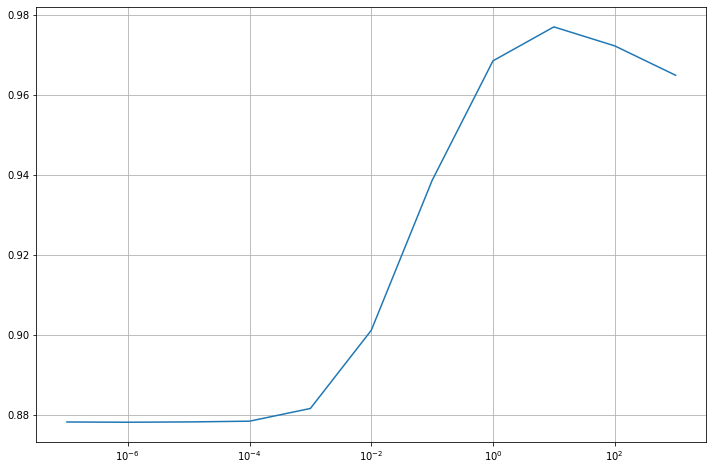

In [25]:
p = np.logspace(-7, 3, 11)
best_C = log_normal(p)

Увеличим масштаб на промежутке, где Score достигает максимума:

Лучшее значение C:  8.576958985908941
Лучшее значение ROC-AUC score:  0.9769854006025003


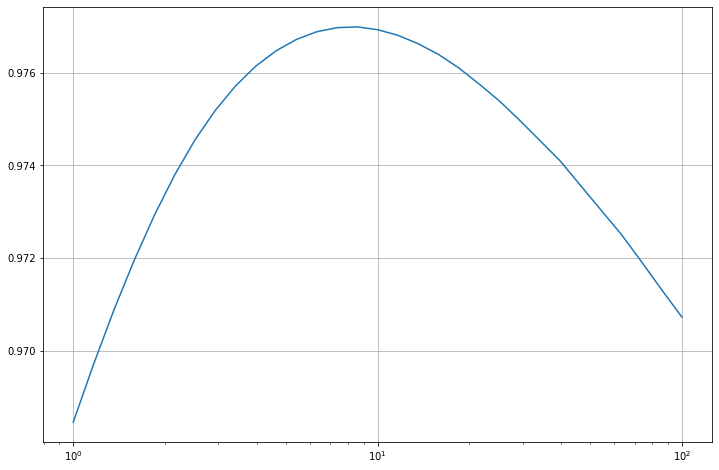

In [26]:
p1 = np.logspace(0, 2, 31)
best_C = log_normal(p1)

Новое значение C увеличило AUC-ROC на кросс-валидации.    
Построим кривые обучения:

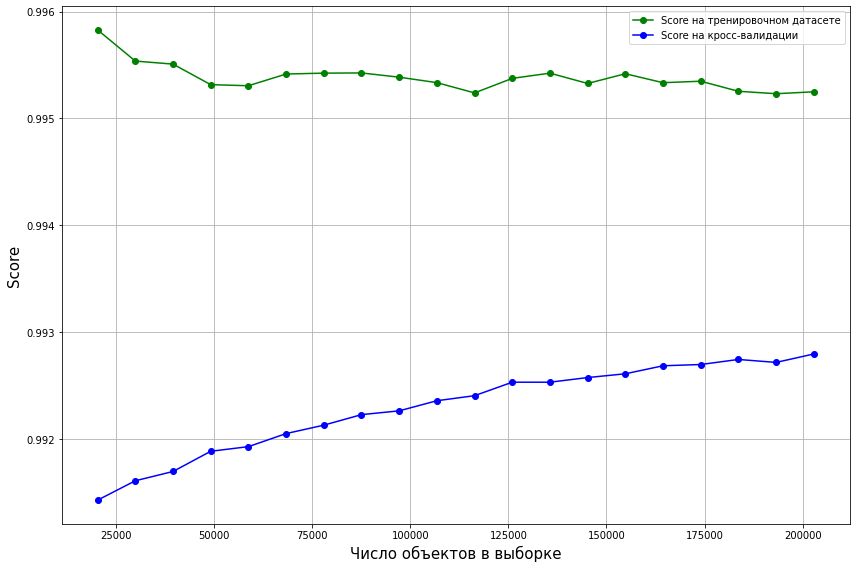

In [27]:
log_reg = LogisticRegression(C = best_C, random_state = 17, n_jobs = -1) 
plot_learning_curve(log_reg)

Из графика кривых обучения видно постепенное улучшение качества на кросс-валидации, но небольшой разрыв всё равно остаётся - свидетельство недообучения, которое можно сократить, если добавить новые признаки, или обучить более мощную модель.
### Оценка модели
Выведем значения основных метрик:

In [29]:
from sklearn.metrics import classification_report
best_model = log_reg.fit(X_train, y)
log_predictions = log_reg.predict(X_train)
print(classification_report(y, log_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251264
           1       0.94      0.50      0.66      2297

    accuracy                           1.00    253561
   macro avg       0.97      0.75      0.83    253561
weighted avg       0.99      1.00      0.99    253561



Модель очень хорошо отсеивает сессии, не принадлежащие Alice, но неверно предсказывает около 50% сессий Alice.
Обучим наилучшую найденную модель на всей обучающей выборке, построим предсказания на тестовой выборке и запишем их в csv-файл.

In [30]:
prediction = best_model.predict_proba(X_test)[:, 1]
predicted_df = pd.DataFrame(prediction,
index = np.arange(1, prediction.shape[0] + 1), columns = ['target'])
predicted_df.to_csv(os.path.join(PATH_TO_DATA, 'final_prediction.csv'), index_label = 'session_id')

### Выводы

Данная модель может быть использована для моментального определения взлома аккаунта, или незаконной передачи аккаунта другому человеку. Её преимущество состоит в том, что она автоматически распознаёт нового пользователя, даже если тот не совершил вредоносных действий. Таким образом, система может блокировать аккаунт и запросить дополнительное подтверждение для входа в него, если обнаружит нехарактерные для обычного пользователя действия, например, повторяющуюся активность в то время и день, когда пользователь обычно отсутствовал. В каких системах информационной безопасности применение данной модели актуально - это другой вопрос, выходящий за рамки данного проекта. 